# **IMPORTAÇÃO DE BIBLIOTECAS**

In [2]:
### BIBLIOTECAS UTILIZADAS NA ETAPA DE MACHINE LEARNING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

## PRÉ-PROCESSAMENTO DOS DADOS

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean
from numba import njit

## RANDOM FOREST e XGBOOST
from sklearn.ensemble import RandomForestRegressor
import xgboost

## SARIMA
import statsmodels as sm
from pmdarima import auto_arima

## LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# OTIMIZAÇÃO
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# **IMPORTAÇÃO DOS DADOS FINAIS**

In [3]:
### IMPORTAÇÃO DOS DADOS FINAIS
path_combs = r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Dataframes'

files = glob.glob(path_combs + '/*.csv')
many_dfs = [pd.read_csv(file, sep=',') for file in files]
df_fuels = pd.concat(many_dfs, ignore_index=False)

df_fuels['data'] = pd.to_datetime(df_fuels['data'])
df_fuels['tipo_comb'] = df_fuels['tipo_comb'].astype('string')

# **PRÉ-PROCESSAMENTO DOS DADOS PARA MODELAGEM**

## FEATURES E SPLIT: VARIÁVEIS & TARGET

In [4]:
## RENOMEANDO AS COLUNAS DE DATA, VARIÁVEL TARGET E IDENTIFICADOR DA SÉRIE TEMPORAL PARA SE ADEQUAR AO MLFORECAST
df_fuels = df_fuels.rename(columns={'data': 'ds', 'preco_medio': 'y', 'tipo_comb': 'unique_id'})

In [5]:
## DEFININDO OS OBJETOS PARA CÁLCULO DAS FEATURES COMO DIFERENÇA, LAGS E MÉDIA MÓVEL

### FUNÇÃO DE DIFERENCIAÇÃO DEFINIDA UTILIZANDO O NUMBA (ADEQUADO AO MLFORECAST)
@njit
def difference(x, lag):
    diff_x = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        diff_x[i] = x[i] - x[i-lag]
    return diff_x

### OBJETO DO MLFORECAST PARA CÁLCULO DE FEATURES COMO LAGS, MÉDIA MÓVEL E VARIÁVEIS DE DATA
get_features = MLForecast(
    models=[],
    freq='D',
    lags=[1,7],
    lag_transforms={
        1: [RollingMean(window_size=3), RollingMean(window_size=7), (difference, 1), (difference, 7)]
    },
    date_features=['dayofweek', 'month', 'year', 'day'],
    num_threads=2
)

### APLICAÇÃO DO OBJETO NO DATAFRAME PARA OBTENÇÃO DAS FEATURES
df_fuels = get_features.preprocess(df_fuels, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

In [6]:
## SEPARAÇÃO DOS DATAFRAMES PARA CADA COMBUSTÍVEL E TAMBÉM DA VARIÁVEL TARGET

X_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA'].drop(columns=['y']).reset_index(drop=True)
X_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL'].drop(columns=['y']).reset_index(drop=True)
y_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA']['y'].reset_index(drop=True)
y_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL']['y'].reset_index(drop=True)

print(f"Número de dias na série temporal do ETANOL:\n{X_etanol.shape[0]} dias.\n")
print(f"Número de dias na série temporal do GASOLINA:\n{X_gasolina.shape[0]} dias.\n")
print(f"Número de variáveis independentes das duas séries:\n{X_etanol.shape[1]} colunas.")

Número de dias na série temporal do ETANOL:
622 dias.

Número de dias na série temporal do GASOLINA:
622 dias.

Número de variáveis independentes das duas séries:
20 colunas.


## SPLIT TREINO/TESTE COM CROSS-VALIDATION

In [7]:
### DIVISÃO EM TREINO E TESTE DOS DATAFRAMES DE COMBUSTÍVEIS SEGUINDO A ESTRATÉGIA DE VALIDAÇÃO CRUZADA DE SÉRIES TEMPORAIS
tscv = TimeSeriesSplit(n_splits=4, test_size=90)
folds_treino_gasolina, folds_treino_etanol = [], []
folds_teste_gasolina, folds_teste_etanol = [], []

for train_index, test_index in tscv.split(X_gasolina):
    folds_treino_gasolina.append(X_gasolina.iloc[train_index])
    folds_teste_gasolina.append(X_gasolina.iloc[test_index])

for train_index, test_index in tscv.split(X_etanol):
    folds_treino_etanol.append(X_etanol.iloc[train_index])
    folds_teste_etanol.append(X_etanol.iloc[test_index])

print("TREINO (GASOLINA e ETANOL)\n-----------------")
for i in range(len(folds_treino_gasolina)):
    fold_shape = folds_treino_gasolina[i].shape[0]
    data_inicio = folds_treino_gasolina[i]['ds'].min().date()
    data_fim = folds_treino_gasolina[i]['ds'].max().date()
    print(f"FOLD_{i}: {fold_shape} datas\tInicio: {data_inicio}\t   Fim: {data_fim}")

print("\nTESTE (GASOLINA e ETANOL)\n-----------------")
for i in range(len(folds_teste_gasolina)):
    fold_shape = folds_teste_gasolina[i].shape[0]
    data_inicio = folds_teste_gasolina[i]['ds'].min().date()
    data_fim = folds_teste_gasolina[i]['ds'].max().date()
    print(f"FOLD_{i}: {fold_shape} datas\tInicio: {data_inicio}\t   Fim: {data_fim}")

TREINO (GASOLINA e ETANOL)
-----------------
FOLD_0: 262 datas	Inicio: 2022-01-13	   Fim: 2023-01-13
FOLD_1: 352 datas	Inicio: 2022-01-13	   Fim: 2023-05-19
FOLD_2: 442 datas	Inicio: 2022-01-13	   Fim: 2023-09-22
FOLD_3: 532 datas	Inicio: 2022-01-13	   Fim: 2024-01-26

TESTE (GASOLINA e ETANOL)
-----------------
FOLD_0: 90 datas	Inicio: 2023-01-16	   Fim: 2023-05-19
FOLD_1: 90 datas	Inicio: 2023-05-22	   Fim: 2023-09-22
FOLD_2: 90 datas	Inicio: 2023-09-25	   Fim: 2024-01-26
FOLD_3: 90 datas	Inicio: 2024-01-29	   Fim: 2024-05-31


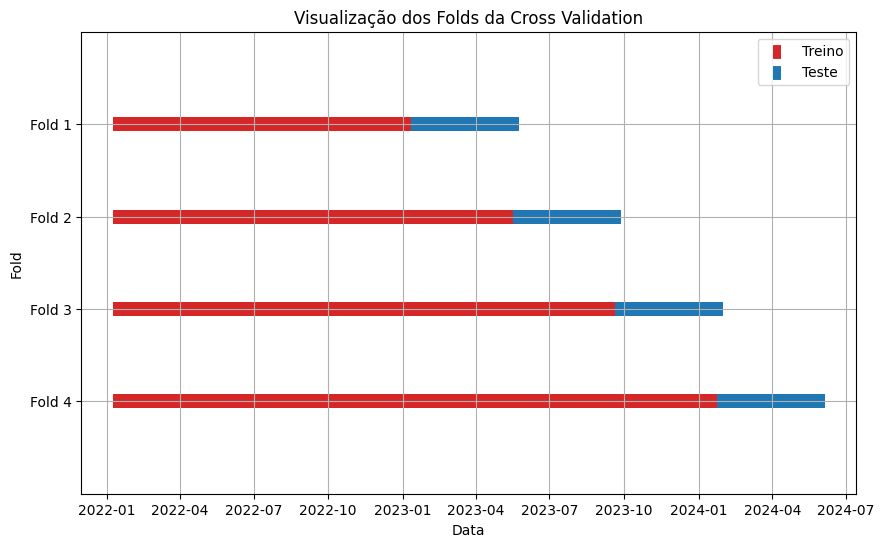

In [8]:
### FUNÇÃO PARA PLOTAR OS FOLDS OBTIDOS COM O SPLIT
def plot_cross_valid(cv_obj, X, y, datas, ax):

    n_splits = cv_obj.get_n_splits()
    
    for i, (train_index, test_index) in enumerate(cv_obj.split(X)):
        ax.scatter(datas[train_index], [i + 0.5] * len(train_index), c='tab:red', marker='_', lw=10, label='Treino' if i == 0 else "")
        ax.scatter(datas[test_index], [i + 0.5] * len(test_index), c='tab:blue', marker='_', lw=10, label='Teste' if i == 0 else "")
    
    ax.set(ylim=[n_splits + 0.5, -0.5], title='Visualização dos Folds da Cross Validation', xlabel='Data', ylabel='Fold')
    ax.legend(loc='best')
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f'Fold {i + 1}' for i in range(n_splits)])
    ax.grid(True)
    return ax

### PLOT DOS FOLDS OBTIDOS COM O SPLIT
fig, ax = plt.subplots(figsize=(10, 6))
datas = X_gasolina['ds']
plot_cross_valid(tscv, X_gasolina, y_gasolina, datas, ax)
plt.show()

# **TREINAMENTO DOS MODELOS USANDO CROSS-VALIDATION**

In [9]:
### REMOÇÃO DE COLUNAS NÃO SUPORTADAS PELOS MODELOS: DATA E STRING
X_etanol.drop(columns=['ds', 'unique_id'], inplace=True)
X_gasolina.drop(columns=['ds', 'unique_id'], inplace=True)

## ARIMA


### ETANOL

In [9]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real_arima = []
preco_etanol_pred_arima = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    best_arima_e = auto_arima(y = y_etanol_train, X = X_etanol_train, m = 7)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = best_arima_e.predict(n_periods = len(X_etanol_test), X = X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real_arima.extend(y_etanol_test)
    preco_etanol_pred_arima.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs: {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.06739947530540295        ||      MAE do FOLD_0: 0.050367575226372835
RMSE do FOLD_1: 0.07038075736022822        ||      MAE do FOLD_1: 0.057512805033273974
RMSE do FOLD_2: 0.059695436388491056        ||      MAE do FOLD_2: 0.046128755832351466
RMSE do FOLD_3: 0.09866334095759868        ||      MAE do FOLD_3: 0.07684603363615249

Média dos RMSEs: 0.07403475250293023        ||      Média dos MAEs: 0.05771379243203768


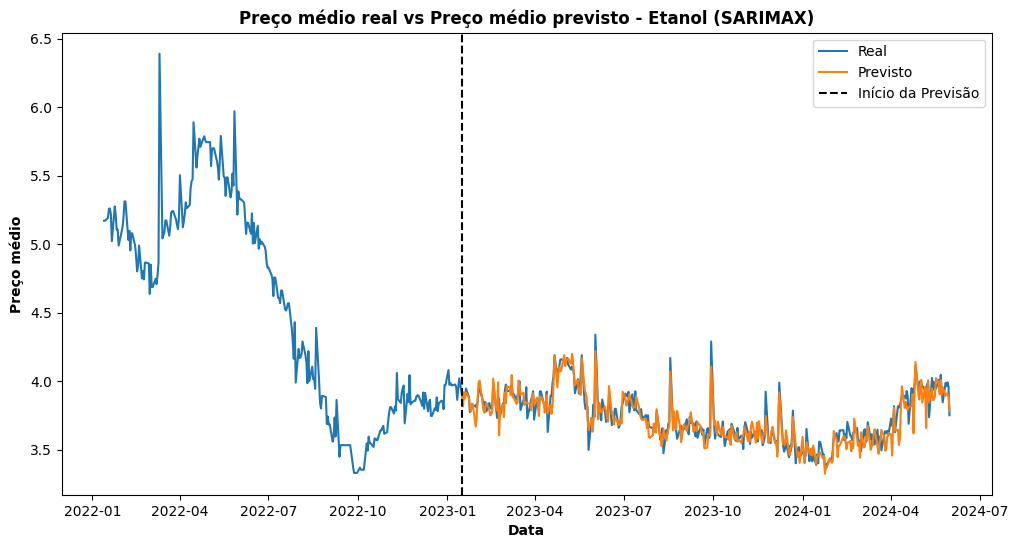

In [10]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real_arima,
    'prediction': preco_etanol_pred_arima
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (SARIMAX)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [10]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real_arima = []
preco_gasolina_pred_arima = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    best_arima_g = auto_arima(y = y_gasolina_train, X = X_gasolina_train, m = 7)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = best_arima_g.predict(n_periods = len(X_gasolina_test), X = X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real_arima.extend(y_gasolina_test)
    preco_gasolina_pred_arima.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs: {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.06982764874636432        ||      MAE do FOLD_0: 0.051129842308173926
RMSE do FOLD_1: 0.08185390411885334        ||      MAE do FOLD_1: 0.06027700434880442
RMSE do FOLD_2: 0.08984259423324045        ||      MAE do FOLD_2: 0.06719300450972705
RMSE do FOLD_3: 0.06957875109755604        ||      MAE do FOLD_3: 0.056899921029804054

Média dos RMSEs: 0.07777572454900354        ||      Média dos MAEs: 0.05887494304912737


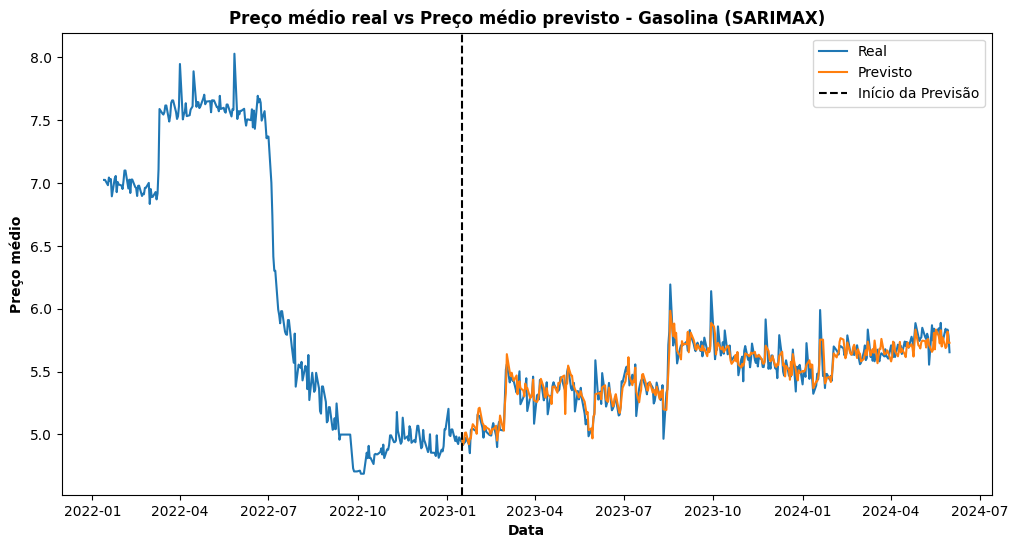

In [11]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real_arima,
    'prediction': preco_gasolina_pred_arima
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (SARIMAX)', fontweight='bold')
plt.legend()
plt.show()

## RANDOM FOREST

In [13]:
params_rf = {
    'n_estimators': 1000,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

rf_model_g = RandomForestRegressor(**params_rf)
rf_model_e = RandomForestRegressor(**params_rf)

### ETANOL

In [14]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = rf_model_e.predict(X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs: {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.08009034662626126        ||      MAE do FOLD_0: 0.05574947368242903
RMSE do FOLD_1: 0.11635010753359117        ||      MAE do FOLD_1: 0.0801605665312741
RMSE do FOLD_2: 0.09466896940753838        ||      MAE do FOLD_2: 0.07275909709190266
RMSE do FOLD_3: 0.07181517930486737        ||      MAE do FOLD_3: 0.056966185340277226

Média dos RMSEs: 0.09073115071806453        ||      Média dos MAEs: 0.06640883066147074


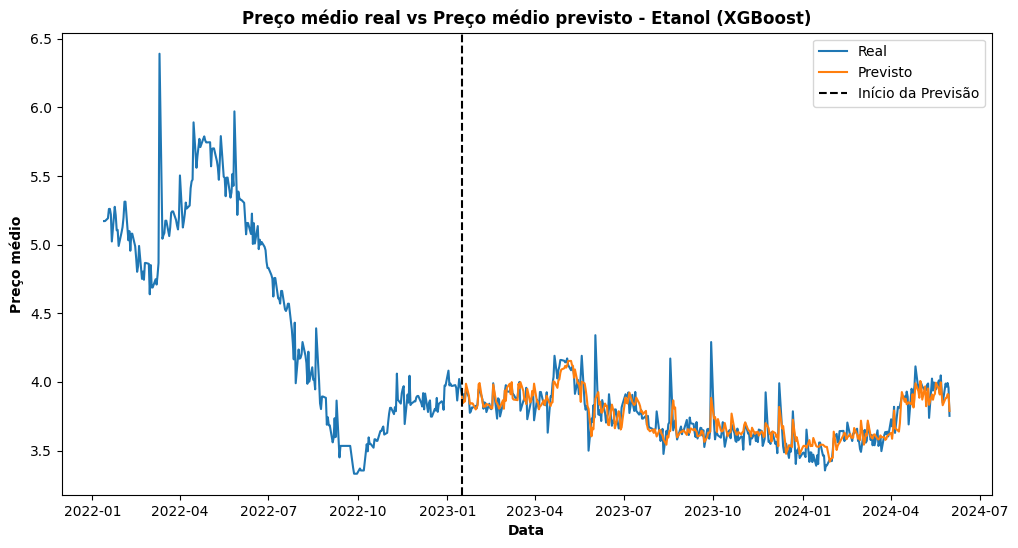

In [15]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [16]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = rf_model_g.predict(X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs: {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.10988412913903459        ||      MAE do FOLD_0: 0.08157859816543861
RMSE do FOLD_1: 0.12725357330930767        ||      MAE do FOLD_1: 0.09575775388068748
RMSE do FOLD_2: 0.1301254470837612        ||      MAE do FOLD_2: 0.09472317340611862
RMSE do FOLD_3: 0.08179912076265604        ||      MAE do FOLD_3: 0.06484666262035069

Média dos RMSEs: 0.11226556757368988        ||      Média dos MAEs: 0.08422654701814886


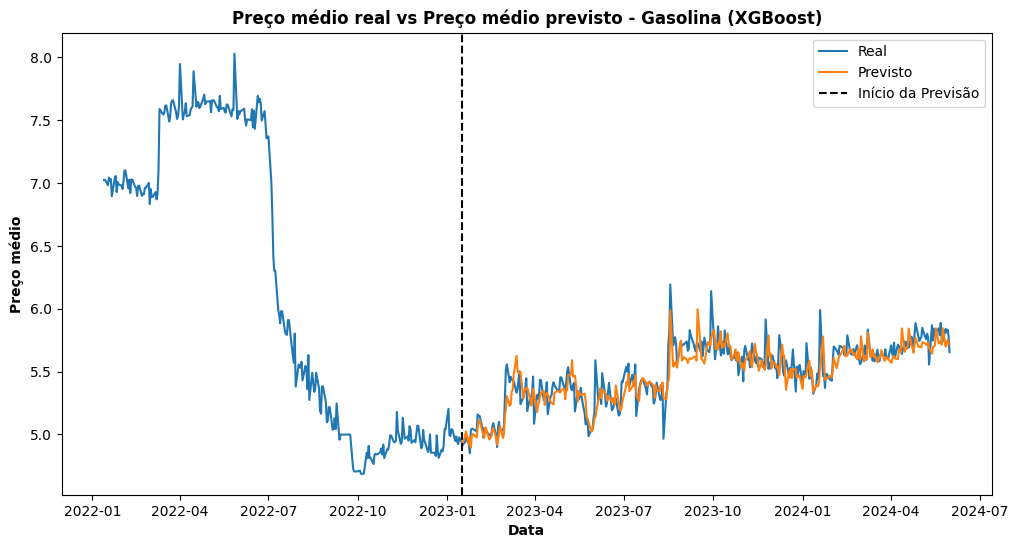

In [17]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

## XGBOOST

In [18]:
## DEFINIÇÃO DOS PARÂMETROS DO MODELO E DO OBJETO DO XGBOOST REGRESSOR
params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 1000
}

xgb_model_g = XGBRegressor(**params_xgb)
xgb_model_e = XGBRegressor(**params_xgb)

### ETANOL

In [19]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = xgb_model_e.predict(X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs: {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.07401570747430865        ||      MAE do FOLD_0: 0.05880394222007933
RMSE do FOLD_1: 0.09253512172344014        ||      MAE do FOLD_1: 0.06776577060208641
RMSE do FOLD_2: 0.11474128710660918        ||      MAE do FOLD_2: 0.0940272977138541
RMSE do FOLD_3: 0.0728128059110023        ||      MAE do FOLD_3: 0.05835065189973307

Média dos RMSEs: 0.08852623055384007        ||      Média dos MAEs: 0.06973691560893822


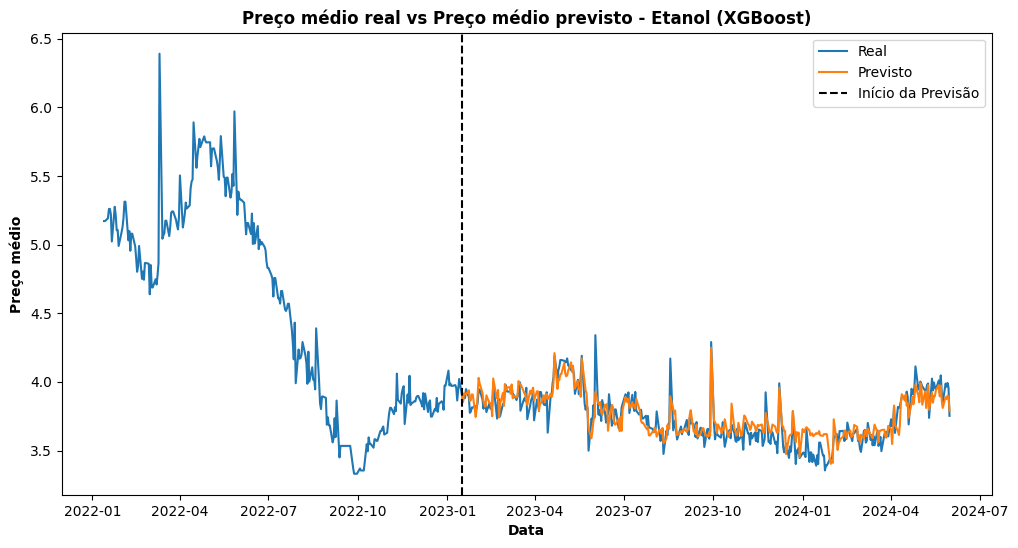

In [20]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [21]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = xgb_model_g.predict(X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs: {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.1306098349406286        ||      MAE do FOLD_0: 0.10952191316658393
RMSE do FOLD_1: 0.12822221714689716        ||      MAE do FOLD_1: 0.07640773293604775
RMSE do FOLD_2: 0.10892347883769006        ||      MAE do FOLD_2: 0.08829340840122901
RMSE do FOLD_3: 0.08640481548087545        ||      MAE do FOLD_3: 0.07038350596004972

Média dos RMSEs: 0.11354008660152282        ||      Média dos MAEs: 0.0861516401159776


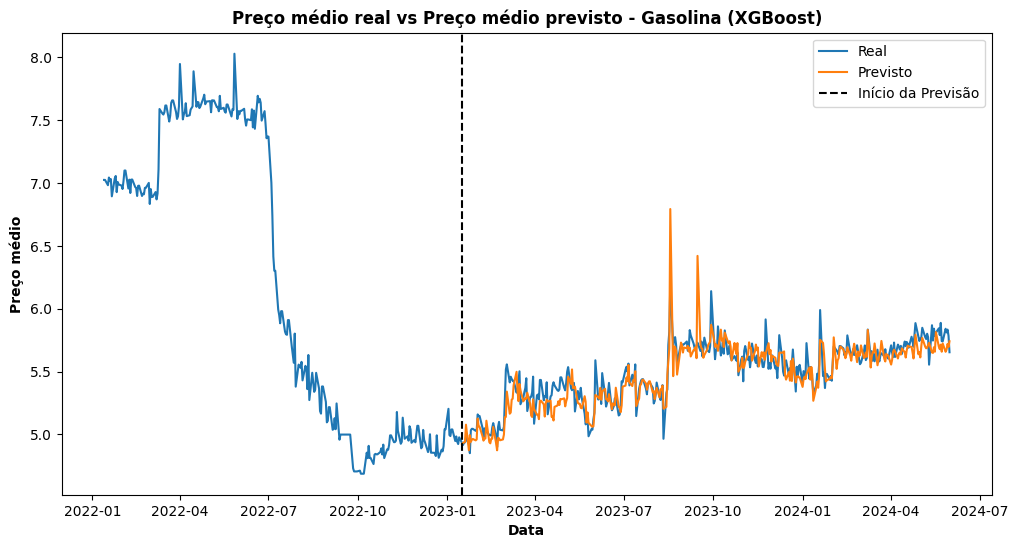

In [22]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

# **OTIMIZAÇÃO DE HIPERPARÂMETROS**

## ESTUDO DE OTIMIZAÇÃO E BUSCA

In [26]:
def objective(trial, X, y, modelo):
    if modelo == 'xgboost':
        params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 20)
        }
        
        model = XGBRegressor(**params)
    
    elif modelo == 'random_forest':
        params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 20)
        }

        model = RandomForestRegressor(**params)

    rmse_opt = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        ### TREINAMENTO DO MODELO
        model.fit(X_train, y_train)
        
        ### PREDIÇÃO E CÁLCULO DO RMSE
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        rmse_opt.append(rmse)

    return np.mean(rmse_opt)

In [27]:
def run_optimize(X, y, modelo, n):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, modelo), n_trials=n)

    print(f"Melhores parâmetros para o modelo {modelo}: {study.best_params}")
    print("_________________________________________________________________")
    return study.best_params

In [28]:
best_params_rf_e = run_optimize(X_etanol, y_etanol, modelo='random_forest', n=50)
best_params_rf_g = run_optimize(X_gasolina, y_gasolina, modelo='random_forest', n=50)

best_params_xgb_e = run_optimize(X_etanol, y_etanol, modelo='xgboost', n=50)
best_params_xgb_g = run_optimize(X_gasolina, y_gasolina, modelo='xgboost', n=50)

Melhores parâmetros para o modelo random_forest: {'n_estimators': 390, 'min_samples_leaf': 2, 'min_samples_split': 3, 'max_depth': 15}
_________________________________________________________________
Melhores parâmetros para o modelo random_forest: {'n_estimators': 291, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 10}
_________________________________________________________________
Melhores parâmetros para o modelo xgboost: {'n_estimators': 959, 'learning_rate': 0.010191579529354435, 'max_depth': 2}
_________________________________________________________________
Melhores parâmetros para o modelo xgboost: {'n_estimators': 129, 'learning_rate': 0.07674476373288527, 'max_depth': 2}
_________________________________________________________________


## RETREINO DOS MODELOS COM MELHORES PARÂMETROS

In [13]:
## RANDOM FOREST PARA CADA COMBUSTÍVEL COM OS PARÂMETROS DO OPTUNA

params_rf_etanol_opt = {
    'n_estimators': 390,
    'max_depth': 15,
    'min_samples_split': 3,
    'min_samples_leaf': 2
}

params_rf_gasolina_opt = {
    'n_estimators': 291,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

rf_model_e = RandomForestRegressor(**params_rf_etanol_opt)
rf_model_g = RandomForestRegressor(**params_rf_gasolina_opt)

In [14]:
## XGBOOST PARA CADA COMBUSTÍVEL COM OS PARÂMETROS DO OPTUNA

params_xgb_etanol_opt = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.010191579529354435,
    'max_depth': 2,
    'n_estimators': 959
}

params_xgb_gasolina_opt = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.07674476373288527,
    'max_depth': 2,
    'n_estimators': 129
}

xgb_model_e = XGBRegressor(**params_xgb_etanol_opt)
xgb_model_g = XGBRegressor(**params_xgb_gasolina_opt)

### ETANOL

In [15]:
## RANDOM FOREST PARA ETANOL COM PARÂMETROS DO OPTUNA
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = rf_model_e.predict(X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs para ETANOL (Random Forest): {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs para ETANOL (Random Forest): {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.0764601965742687        ||      MAE do FOLD_0: 0.054801195940696976
RMSE do FOLD_1: 0.11328473762198638        ||      MAE do FOLD_1: 0.0781266211570019
RMSE do FOLD_2: 0.09818614149020058        ||      MAE do FOLD_2: 0.0799578360666657
RMSE do FOLD_3: 0.07114411167091253        ||      MAE do FOLD_3: 0.05831213521373764

Média dos RMSEs para ETANOL (Random Forest): 0.08976879683934205        ||      Média dos MAEs para ETANOL (Random Forest): 0.06779944709452555


In [16]:
## XGBOOST PARA ETANOL COM PARÂMETROS DO OPTUNA
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = xgb_model_e.predict(X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs para ETANOL (XGBoost): {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs para ETANOL (XGBoost): {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.07199773169256504        ||      MAE do FOLD_0: 0.05479582540863945
RMSE do FOLD_1: 0.08319392209976657        ||      MAE do FOLD_1: 0.06327042577929586
RMSE do FOLD_2: 0.08374545909899801        ||      MAE do FOLD_2: 0.06692025114329354
RMSE do FOLD_3: 0.07817451701475242        ||      MAE do FOLD_3: 0.0610426583501209

Média dos RMSEs para ETANOL (XGBoost): 0.07927790747652051        ||      Média dos MAEs para ETANOL (XGBoost): 0.06150729017033744


### GASOLINA

In [17]:
## RANDOM FOREST PARA GASOLINA COM PARÂMETROS DO OPTUNA
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = rf_model_g.predict(X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs para GASOLINA (Random Forest): {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs para GASOLINA (Random Forest): {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.10807485875675056        ||      MAE do FOLD_0: 0.08509593999358746
RMSE do FOLD_1: 0.12119468921428267        ||      MAE do FOLD_1: 0.09176976533223612
RMSE do FOLD_2: 0.12188177625274414        ||      MAE do FOLD_2: 0.0919469760794781
RMSE do FOLD_3: 0.09230648954818775        ||      MAE do FOLD_3: 0.07658084838451265

Média dos RMSEs para GASOLINA (Random Forest): 0.11086445344299128        ||      Média dos MAEs para GASOLINA (Random Forest): 0.08634838244745358


In [18]:
## XGBOOST PARA GASOLINA COM PARÂMETROS DO OPTUNA
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = xgb_model_g.predict(X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs para GASOLINA (XGBoost): {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs para GASOLINA (XGBoost): {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.10186755024702593        ||      MAE do FOLD_0: 0.07978683749957913
RMSE do FOLD_1: 0.10869402667708603        ||      MAE do FOLD_1: 0.0794518987552309
RMSE do FOLD_2: 0.09296952362089217        ||      MAE do FOLD_2: 0.07016351249405346
RMSE do FOLD_3: 0.0797263135959738        ||      MAE do FOLD_3: 0.06625417564636749

Média dos RMSEs para GASOLINA (XGBoost): 0.09581435353524448        ||      Média dos MAEs para GASOLINA (XGBoost): 0.07391410609880775


# **INTERPRETAÇÃO DO MODELO**

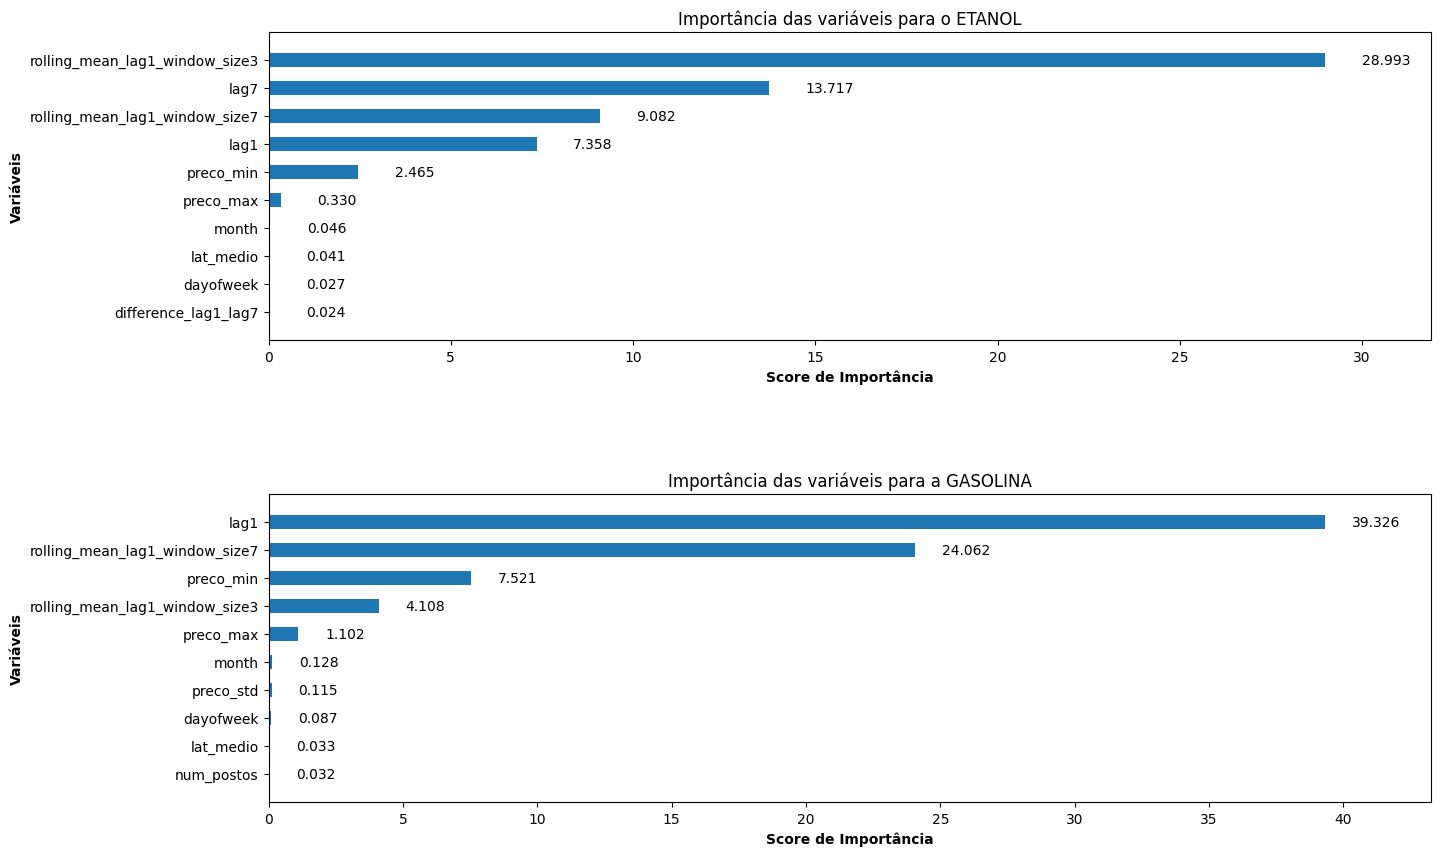

In [62]:
# PLOTANDO A FEATURE IMPORTANCE DO MODELO XGBOOST PARA AS VARIÁVEIS DO ETANOL E GASOLINA

fig, ax = plt.subplots(2,1, figsize=(15,10))

## IMPORTÂNCIA DAS VARIÁVEIS PARA O MODELO APLICADO AO ETANOL

xgboost.plot_importance(xgb_model_e,
                        ax=ax[0],
                        importance_type='gain',
                        max_num_features=10,
                        title='Importância das variáveis para o ETANOL',
                        height=0.5,
                        grid=False,
                        values_format='{v:.3f}',
                        xlabel='Score de importância (Gain)',
                        ylabel='Variáveis')


## IMPORTÂNCIA DAS VARIÁVEIS PARA O MODELO APLICADO A GASOLINA

xgboost.plot_importance(xgb_model_g,
                        ax=ax[1],
                        importance_type='gain',
                        max_num_features=10,
                        title='Importância das variáveis para a GASOLINA',
                        height=0.5,
                        grid=False,
                        values_format='{v:.3f}',
                        xlabel='Score de importância (Gain)',
                        ylabel='Variáveis')

for axs in ax:
    axs.set_xlabel('Score de Importância', fontweight='bold')
    axs.set_ylabel('Variáveis', fontweight='bold')


plt.subplots_adjust(hspace=0.5)
plt.show()

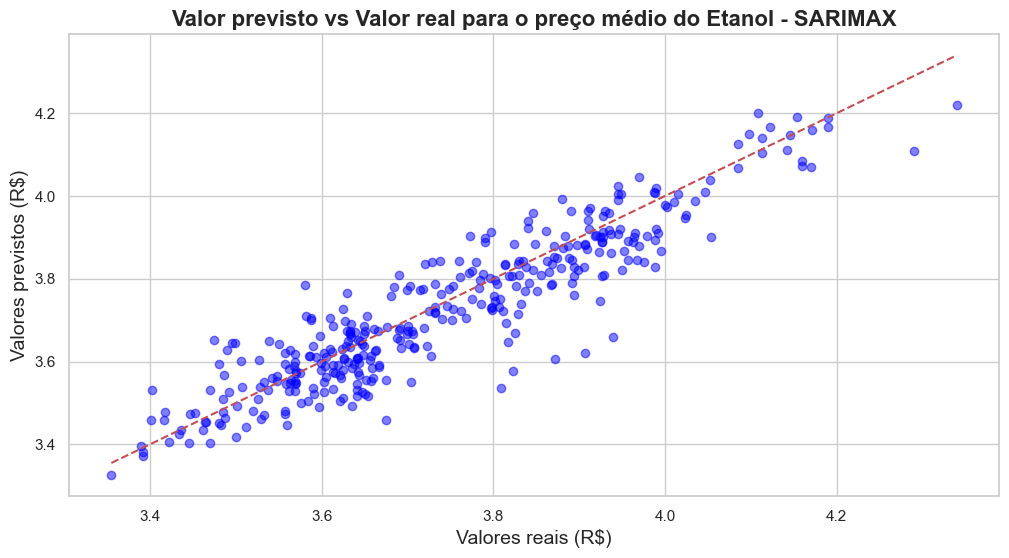

In [135]:
# PLOT DO VALOR REAL VS VALOR PREVISTO PARA O ETANOL
plt.figure(figsize=(12,6))

plt.scatter(preco_etanol_real_arima, preco_etanol_pred_arima, alpha=0.5, color='blue')
plt.plot([min(preco_etanol_real_arima), max(preco_etanol_real_arima)], [min(preco_etanol_real_arima), max(preco_etanol_real_arima)], 'r--')

plt.title('Valor previsto vs Valor real para o preço médio do Etanol - SARIMAX', fontweight='bold', fontsize=16)
plt.grid(True)
plt.xlabel('Valores reais (R$)', fontsize=14)
plt.ylabel('Valores previstos (R$)', fontsize=14)
plt.show()

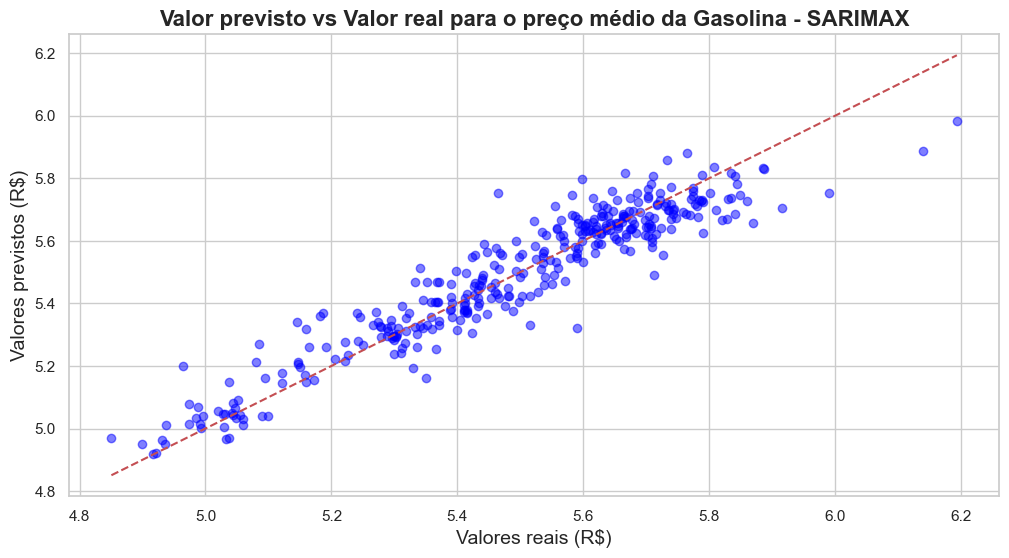

In [134]:
# PLOT DO VALOR REAL VS VALOR PREVISTO PARA A GASOLINA
plt.figure(figsize=(12,6))

plt.scatter(preco_gasolina_real_arima, preco_gasolina_pred_arima, alpha=0.5, color='blue')
plt.plot([min(preco_gasolina_real_arima), max(preco_gasolina_real_arima)], [min(preco_gasolina_real_arima), max(preco_gasolina_real_arima)], 'r--')

plt.title('Valor previsto vs Valor real para o preço médio da Gasolina - SARIMAX', fontweight='bold', fontsize=16)
plt.grid(True)
plt.xlabel('Valores reais (R$)', fontsize=14)
plt.ylabel('Valores previstos (R$)', fontsize=14)
plt.show()

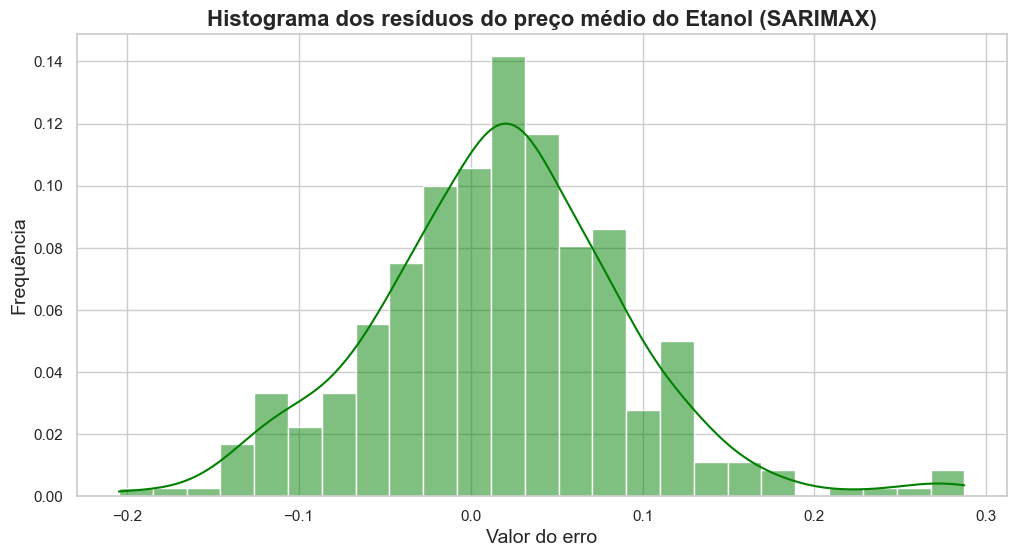

In [129]:
# HISTOGRAMA DOS ERROS DO MODELO FINAL PARA O PRECO MÉDIO DO ETANOL
residuals_e = pd.Series(preco_etanol_real_arima) - pd.Series(preco_etanol_pred_arima)
plt.figure(figsize=(12,6))
#sns.set_theme(style='whitegrid')


sns.histplot(residuals_e, kde=True, color='green', bins=25, stat='proportion')

plt.title('Histograma dos resíduos do preço médio do Etanol (SARIMAX)', fontweight='bold', fontsize=16)
plt.xlabel('Valor do erro', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.show()

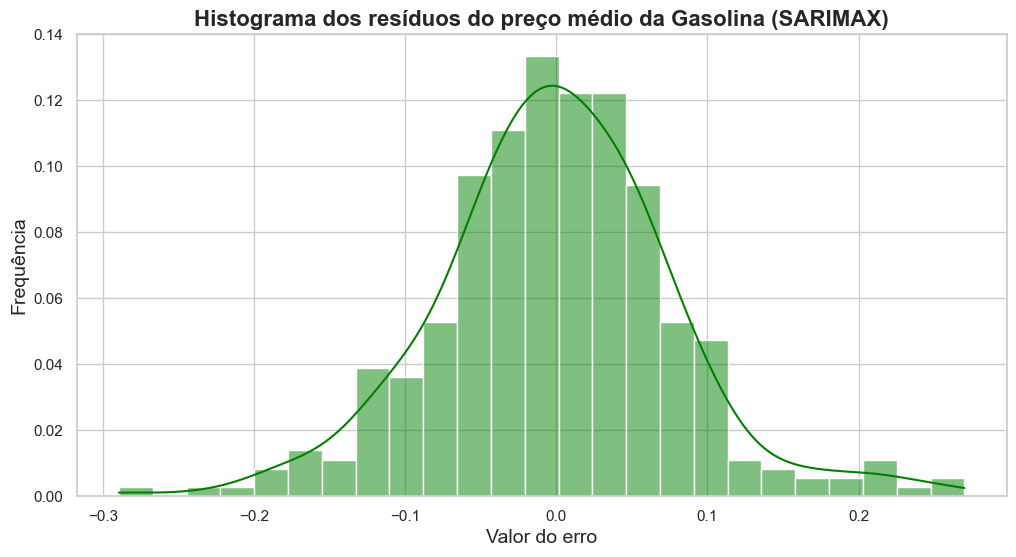

In [130]:
# HISTOGRAMA DOS ERROS DO MODELO FINAL PARA O PRECO MÉDIO DA GASOLINA
residuals_g = pd.Series(preco_gasolina_real_arima) - pd.Series(preco_gasolina_pred_arima)
plt.figure(figsize=(12,6))
sns.set_theme(style='whitegrid')


sns.histplot(residuals_g, kde=True, color='green', bins=25, stat='proportion')

plt.title('Histograma dos resíduos do preço médio da Gasolina (SARIMAX)', fontweight='bold', fontsize=16)
plt.xlabel('Valor do erro', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.show()